# Predição dos números de passageiros entrantes

Neste notebook será feita a predição dos passageiros entrantes. Duas abordagens serão analisadas:


### Ajuste da função seno

Iremos decompor o sinal em suas partes que representam a sazonalidade e a tendência linear de aumento. Em seguida iremos realizar uma regressão linear e um ajuste da função seno, combinar as predições de cada uma delas, e enfim estimar o número de passageiros

### SARIMA

Um modelo SARIMA é capaz de modelar séries que apresentam um componente sazonal, baseado em um modelo ARIMA, com características de Auto-Regressão (AR), Integração (I) e Média Movel (MA, *Moving Average*)



In [458]:
# Importação dos dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Pasta para armazenar os modelos
if not os.path.exists('Models/'):
    os.makedirs('Models/')

################ AVISOS
import warnings
warnings.filterwarnings("ignore")
########## Comentar caso queira ver os aviso
# Inseri esta linha pois já tenho ciência de todos os avisos presentes neste notebook

file_df = 'airline_2009_2019.csv'
file_data = 'data.csv'
folder = 'ProcessedData/'
df = pd.read_csv(folder+file_df)
data =pd.read_csv(folder+file_data)
data.head(10)

,Unnamed: 0,Month,Passengers In,Freight In,Passengers Out,Freight Out
0,0,2009-01-01,3021.0,4.313,1959.0,8.311
1,1,2009-01-01,627.0,76.260,1821.0,68.539
2,2,2009-01-01,6658.0,4.918,5365.0,68.621
3,3,2009-01-01,7489.0,174.828,6424.0,105.191
4,4,2009-01-01,12458.0,201.314,11163.0,142.408
5,5,2009-01-01,4635.0,36.586,3782.0,80.174
6,6,2009-01-01,94.0,0.000,39.0,0.000
7,7,2009-01-01,0.0,1.136,0.0,0.000
8,8,2009-01-01,109904.0,1811.254,100460.0,1385.565
9,9,2009-01-01,0.0,164.046,0.0,0.000


## Divisão de dados de treino e teste
Os anos de 2009 a 2018 serão usados como base para construção das técnicas preditivas, enquanto o ano de 2019 será usado para validação

In [295]:
data_train = data[data["Month"] < '2019-01-01'].copy()
data_test = data[data["Month"] >= '2019-01-01'].copy()

df_train = df[df["Month"] < '2019-01-01'].copy()
df_test = df[df["Month"] >= '2019-01-01'].copy()


## Decomposição do sinal

Iremos utilizar uma decomposição multiplicativa do sinal, de forma a separar a tendência e a sazonalidade da série.
Este método assume que a série $y_t$ é: 

$y_t = T_t*S_t*R_t$

Onde $T_t, S_t, R_t$ são a tendência, sazonalidade e resíduos respectivamente. A tendência é estimada com uma janela de média móvel, e a sazonalidade pela divisão da série pela tendência. 

A decomposição multiplicativa foi escolhida porque os efeitos da sazonalidade aparentam aumentar conforme a tendência aumenta. 

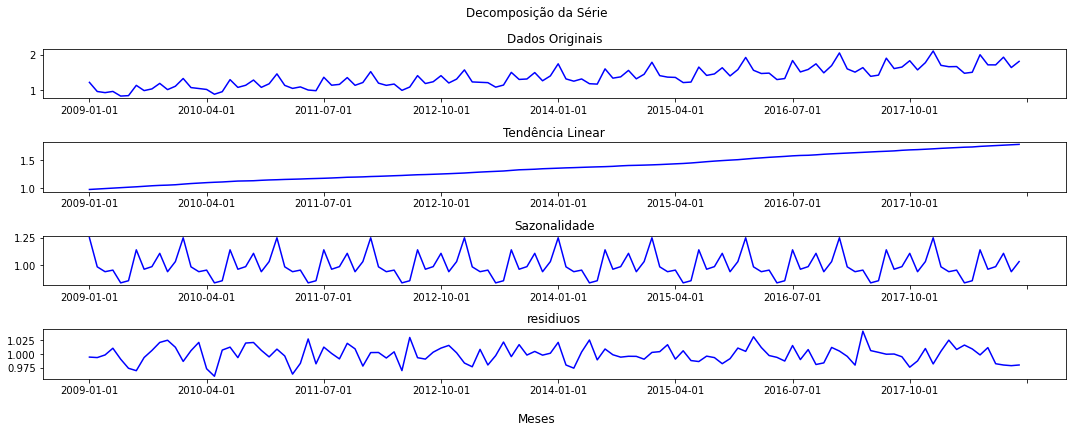

In [498]:
## Decomposição do sinal


# Decomposição do sinal 
# Média móvel
from statsmodels.tsa.seasonal import seasonal_decompose

# Passageiros In por mês
passIn_train = data_train.groupby('Month')['Passengers In'].sum()/1e6
passIn_teste = data_test.groupby('Month')['Passengers In'].sum()/1e6

decomposition = seasonal_decompose(passIn_train, 
                   model='multiplicative', 
                   period=12, 
                   extrapolate_trend='freq')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(nrows=4,ncols=1,
                        figsize=(15,6))


axs[0].plot(passIn_train.index,passIn_train.values, color = 'b')
axs[0].set_title('Dados Originais')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(11))

axs[1].plot(trend, color = 'b')
axs[1].set_title('Tendência Linear')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(11))

axs[2].plot(seasonal, color = 'b')
axs[2].set_title('Sazonalidade')
axs[2].xaxis.set_major_locator(plt.MaxNLocator(11))

axs[3].plot(residual, color = 'b')
axs[3].set_title('residiuos')
axs[3].xaxis.set_major_locator(plt.MaxNLocator(11))

fig.suptitle('Decomposição da Série')
fig.supxlabel('Meses')
plt.tight_layout()
plt.savefig('Images/signal_decomp.jpeg')
plt.show()


Podemos comprovar aqui que há de fato uma tendência linear de aumento e uma sazonalidade anual. Nota-se também uma sazonalidade de período e amplitude menor, que é vísivel principalmente no segundo semestre de cada ano. 

Uma das maneiras de obter uma previsão do número de futuros passageiros entrantes seria a partir da modelagem tanto da tendência quanto da sazonalidade. Neste caso, optou-se por não modelar os resídiuos pois estão centrados ao redor de um e com uma baixa variação, de apenas $\pm$ 2.5%. $R_t$ será considera igual a 1.

As estimativas serão então obtidas através da equação

$\hat{y}_t = \hat{T}_t*\hat{S}_t*1$

Para avaliação das predições e qualidade dos ajustes, será usada a métrica *Mean Squared Error* (MSE). Quanto mais próxima de zero, melhor foi o ajuste. 

#### Modelagem da tendência - Regressão Linear 
Para modelar a tendência, uma simples regressão linear é o suficiente 

A métrica MSE para a tendência é: 0.000304


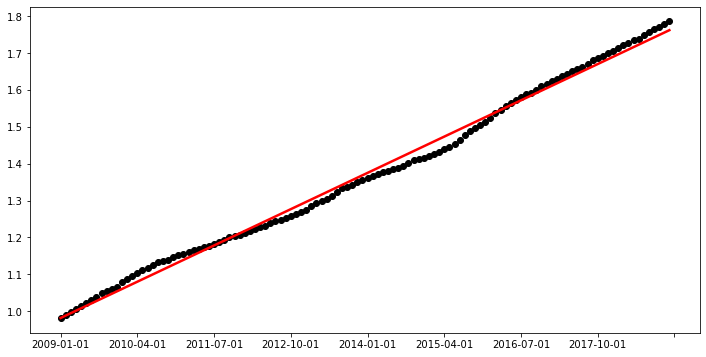

In [234]:
#### Regressão Linear da tendência 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#reg = LinearRegression().fit(trend.index, trend.values)
X_trend = trend.index.factorize()[0].reshape(-1,1)
y_trend = trend.values

reg = LinearRegression().fit(X_trend, y_trend)

ytrend_pred = reg.predict(X_trend)

# Dados de treinamento
fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(trend.index, trend.values, color = 'k', label = 'Linha de Tendência')
ax.plot(trend.index, ytrend_pred, color = 'r', label = 'Regressão linear',
        linewidth = 2.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(11))

ax.set_title('Regressão Linear da Tendência')
# Dados de teste

# Avaliação nos dados de treino
print(f'A métrica MSE para a tendência é: {mean_squared_error(y_trend,ytrend_pred):5f}')

A qualidade do ajuste é considerada satisfatória com base no MSE.

#### Modelagem da sazonalidade - Regressão Linear 


Para modelar o comportamento sazonal, ajustaremos uma função com duas componentes senoidais aos dado, para tentar capturar ambos os padrões identificados. A definição dos pontos iniciais são de extrema importância ao utilizar a otimização por minímos quadrados não lineares, principalmente a frequências das componentes senoidais. 

Os pontos iniciais foram estimados com base no período de ambas as sazonalidades, 12 e 3 meses respectivamente

A métrica MSE para a componente sazonal é: 0.003093


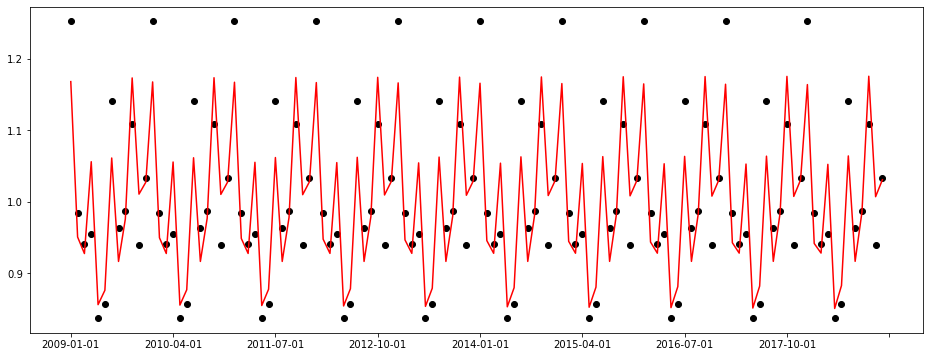

In [235]:
### Sine wave fitting
#plt.axvspan(passIn_teste.index[0], passIn_teste.index[-1], alpha=0.5, color='lightgrey')

#ax.plot()
## Modelagem série senoidais

X_season = seasonal.index.factorize()[0].reshape(-1,1)
y_season = seasonal.values

from scipy.optimize import curve_fit

def fitsine(X,a, b,c, d,e,f,g):
    sinewave = a*np.sin(b*X + c) + d*np.cos(e*X+f) + g
    return sinewave

popt, pcov = curve_fit(fitsine, X_season.ravel(), y_season.ravel(),p0=[0.5,2*np.pi/12,1,-0.5,2*np.pi/3,2,1], maxfev=1000)  

yseason_pred =  fitsine(X_season, *popt)

fig, ax = plt.subplots(figsize = (16,6))
ax.scatter(seasonal.index, y_season, color='k')
ax.plot(seasonal.index,yseason_pred, 
         label="Fitted Curve", 
        color = 'r')
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
ax.set_title('Ajuste da função seno')

print(f'A métrica MSE para a componente sazonal é: {mean_squared_error(y_season,yseason_pred):5f}')


A qualidade do ajuste é considerada satisfatória com base no MSE.

C:\Users\pedro\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


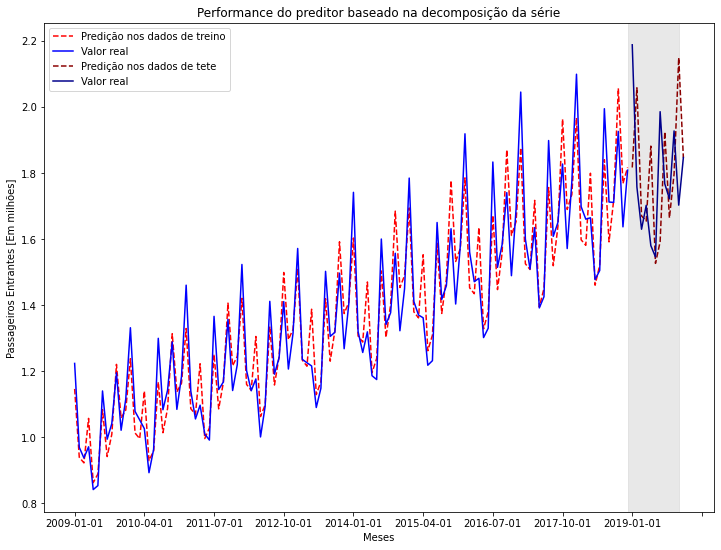

A métrica MSE nos dados de treino é: 0.006777
A métrica MSE nos dados de teste é: 0.060112


In [497]:
# Predição na série completa 

# Dados de treino
trend_pred = reg.predict(X_season)
season_pred = fitsine(X_season, *popt).ravel()
predictions = season_pred*trend_pred
# Plotagem
fig, ax = plt.subplots(figsize = (12,9))
ax.plot(passIn_train.index,predictions, label = 'Predição nos dados de treino', color = 'r', linestyle = '--')
ax.plot(passIn_train.index, passIn_train.values, label = 'Valor real', color='b')

# Dados de teste
X_teste = X_season[-1] + passIn_teste.index.factorize()[0].reshape(-1,1)
trend_pred_tst = reg.predict(X_teste)
season_pred_tst = fitsine(X_teste, *popt).ravel()
predictions_tst = season_pred_tst*trend_pred_tst
# Plotagem
ax.axvspan(X_teste[0], X_teste[-1], alpha=0.5, color='lightgrey')
ax.plot(passIn_teste.index,predictions_tst, label = 'Predição nos dados de tete', color = 'darkred', linestyle = '--')
ax.plot(passIn_teste.index, passIn_teste.values, label = 'Valor real', color='darkblue')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.legend()
ax.set_xlabel('Meses')
ax.set_ylabel('Passageiros Entrantes [Em milhões]')
ax.set_title('Performance do preditor baseado na decomposição da série')
plt.savefig('Images/Pred_sinewave.jpeg')
plt.show()


print(f'A métrica MSE nos dados de treino é: {mean_squared_error(passIn_train.values,predictions):5f}')
print(f'A métrica MSE nos dados de teste é: {mean_squared_error(passIn_teste.values,predictions_tst):5f}')

Podemos observar na figura acima a performance desta abordagem de predição. Na área cinzenta temos o valor real e a predição nos dados de teste, e no restante do mapa, nos dados de treino. No geral, esta abordagem foi capaz de detectar de forma correta a sazonalidade nos dados de treino, acompanhando os picos e quedas na série, mas não nos dados de teste. Isto é evidenciado também pelo fato do MSE de teste ser aproximadamente 9 vezes maior que o de teste. 

## SARIMA

Para aplicar a modelagem SARIMA, precisamos verificar antes a estacionaridade da série, e caso ela não seja, estacionarizá-la. 

#### Teste de estacionaridade

Realizaremos o teste Dickey-Fuller, um teste de raz unitária. A hipótese nula $H_0$ neste caso é de que a série seja estacionária. Necessitamos de um $p < 0,05$ para rejeitá-la

In [237]:
from statsmodels.tsa.stattools import adfuller


def df_test(X, pvalue = 0.05):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] > pvalue:
        print('Hipótese nula H0 não é rejeitada: A série não é estacionária')
    else:
        print('Hipóte nula é rejeitada: A série pode ser estacionária')
        
df_test(passIn_train)  

ADF Statistic: 1.470389
p-value: 0.997412
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Hipótese nula H0 não é rejeitada: A série não é estacionária


#### Estacionarização

Como tivemos um valor p alto, a hipótese nula não é rejeitada. Ou seja, a série não é estacionaria, e possui uma raiz unitária.
Para torná-la estacionária, modelaremos os dados com base nas primeiras diferenças logarítimicas.


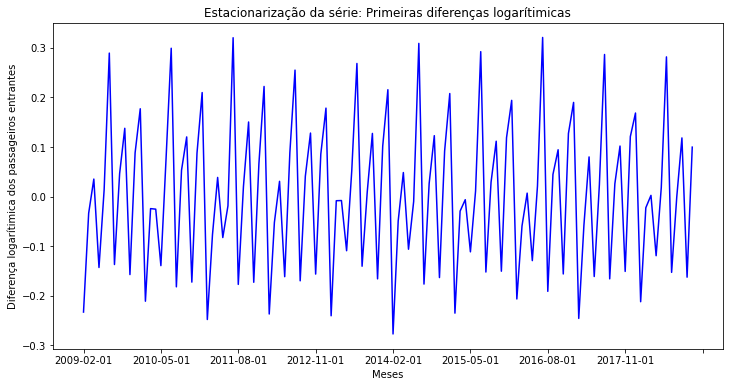

In [238]:
first_diff = np.log(passIn_train).diff()[1:]

fig, ax = plt.subplots(figsize = (12,6))    
#
ax.plot(first_diff.index, first_diff.values, color = 'b')
ax.set_xlabel('Meses')
ax.set_ylabel('Diferença logarítimica dos passageiros entrantes')
ax.set_title('Estacionarização da série: Primeiras diferenças logarítimicas')
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
plt.show()

Esta série aparenta ter média e variância constantes, e ser centrada ao redor de zero. Refaremos o teste de DF para verificar se é mesmo estacionária:


In [239]:
df_test(first_diff)

ADF Statistic: -4.267773
p-value: 0.000505
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Hipóte nula é rejeitada: A série pode ser estacionária


Um modelo SARIMA é da forma: 
    
    SARIMA(p, d, q) (P, D, Q)lag

Contendo termos que correspondem à sazonalidade da série. Para escolha destes parâmetros, iremos analisar a Autocorrelação (ACF) e Autocorrelação Parcial (PACF) da série:

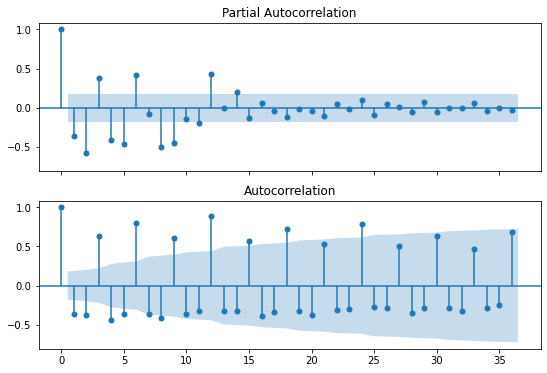

In [240]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2,ncols=1,
                        sharex=True, sharey=True,
                        figsize=(9,6))

plot_pacf(first_diff, ax = axs[0], method='ywm', lags=36)
plot_acf(first_diff, ax = axs[1], lags=36)
plt.show()



#### Estimando termos AR
A partir da Autocorrelação Parcial, podemos estimar o número de termos AR a ser usados. Neste caso, estimamos até 6 termos AR, pois o *lag* 7 é o primeiro a estar dentro do intervalo de confiança.

#### Estimando termos I
Como usamos primeiras diferenças, teremos um termo I

#### Estimando termos MA
A partir da Autocorrelação, estimamos 6 termos MA, pois assim como no caso anterior, o *lag* 7 é o primeiro a entrar no intervalo de confiança. 

#### Estimando termos AR sazonais (SAR)

Para estimar os termos AR sazonais, devemos observar novamente a PACF. Nossa série tem uma sazonalidade anual, então observaremos o *lag* 12. Como ele está fora do intervalo de confiança, mas o *lag* 24 não, usaremos 1 termo SAR.

#### Estimando termos I sazonais

Como foi usada a diferenciação logarítimica, e não uma diferenciação com base na sazonalidade (por exemplo, $Y(t-12)$), não seria necessário um termo I sazonal. Adicionaremos este termo da mesma forma pois geralmente a presença dele traz consigo um aumento na performance. 

#### Estimando termos MA sazonais (MAS)
Para os termos MAS, seguiremos a mesma lógica dos SAR. Ambos os *lags* 12 e 24 representam picos significativos, com o 36 estando no limite do intervalo de confiança. Usaremos então 2 termos MAS

Atraves da análise visual, nosso modelo SARIMA seria da forma: **SARIMA(6, 1, 6) (1, 0, 2)12**

No entanto, iremos tentar diferentes combinações destes parâmetros, e verificar qual deles retorna a métrica de avaliação escolhida, no caso, o Critério de Informação Akaike (AIC, Akaike Informatio Criteria)



In [412]:
from itertools import product

p = range(0, 6, 1)
d = 1
q = range(0, 6, 1)
P = range(0, 1, 1)
D = 1
Q = range(0, 2, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(f'Teremos {len(parameters_list)} combinações possíveis!')

# Importar a função do modelo
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Função para mostrar uma barra de progresso
from tqdm.notebook import tqdm

def optimize_SARIMA(parameters_list, d, D, s, var):
    """
        Retorna uma dataframe com os parâmetros e AIC
        
        parameters_list - lista com os parâmetros (p, q, P, Q) 
        d - ordem de integração
        D - ordem de integração sazonal
        s - periocidade
        var - variável exogênea
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(var, 
                            order=(param[0], d, param[1]), 
                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Ordenar 
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Ajustar a frequência do índice
first_diff.index = pd.DatetimeIndex(first_diff.index.values,
                               freq='MS')

result_df = optimize_SARIMA(parameters_list, 1, 0, 12, first_diff)

result_df


Teremos 72 combinações possíveis!


  0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarnin

C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

,"(p,q)x(P,Q)",AIC
0,"(2, 5, 0, 1)",-350.076857
1,"(5, 5, 0, 1)",-346.686177
2,"(5, 4, 0, 1)",-335.744084
3,"(4, 5, 0, 1)",-334.756015
4,"(2, 3, 0, 1)",-334.303093
...,...,...
67,"(0, 1, 0, 0)",-99.159722
68,"(0, 0, 0, 1)",-98.267499
69,"(1, 2, 0, 0)",-97.709125
70,"(1, 0, 0, 0)",-19.731122


C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                        Passengers In   No. Observations:                  119
Model:             SARIMAX(5, 1, 5)x(0, 1, [1], 12)   Log Likelihood                 257.741
Date:                              Sun, 20 Mar 2022   AIC                           -491.481
Time:                                      19:45:24   BIC                           -459.520
Sample:                                  02-01-2009   HQIC                          -478.527
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8716      0.844     -2.218      0.027      -3.525      -0.218
ar.L2         -2.15

C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


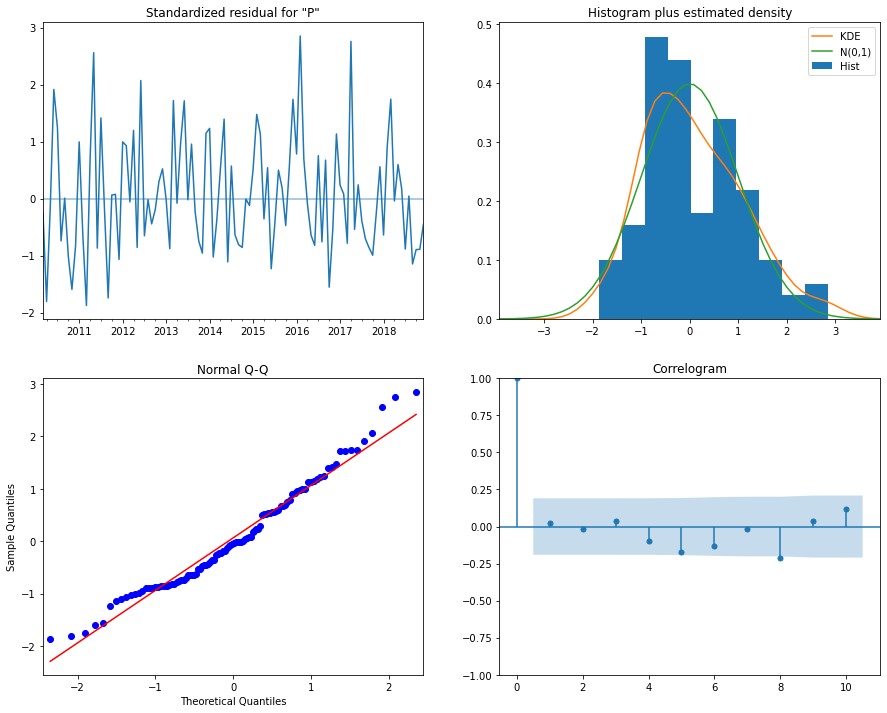

In [413]:
best_model = SARIMAX(first_diff, order=(5, 1, 5), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())

best_model.plot_diagnostics(figsize=(15,12));


A melhor estrutura do modelo é selecionada e usada com os dados de treinamento. O correlograma dos resíduos mostra que não há uma autocorrelação significativa, o que indica que estes são um ruído branco. Ou seja, este modelo é apropriado para os dados. 
Podemos seguir para avaliação da performance

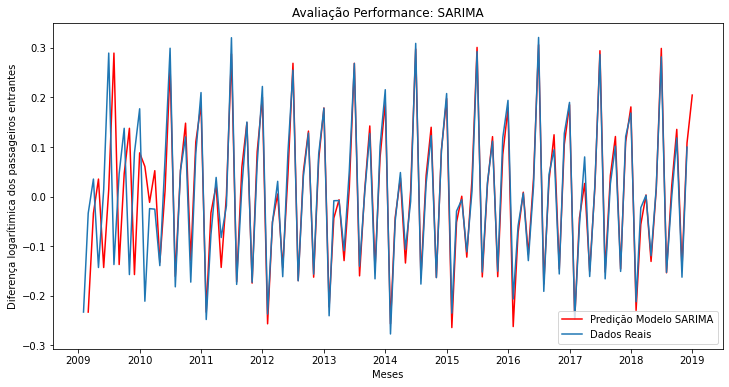

A métrica MSE nos dados de treino é: 0.056479


In [414]:
forecast = best_model.predict(start=1, end=first_diff.shape[-1])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(forecast, color='r', label='Predição Modelo SARIMA')
ax.plot(first_diff, label='Dados Reais')
ax.legend()

ax.set_xlabel('Meses')
ax.set_ylabel('Diferença logarítimica dos passageiros entrantes')
ax.set_title('Avaliação Performance: SARIMA')

plt.show()

print(f'A métrica MSE nos dados de treino é: {mean_squared_error(first_diff.values,forecast.values):5f}')

In [415]:
# Retornando ao número de passageiros
# Realizar a operação Inversa de Log - Diff 
# Cumsum - Exp (Com o primeiro valor da série)
y0 = np.log(passIn_train.values[0])

def reverse_logdiff(y0,series):
    rev_diff = np.concatenate(([y0],series))
    res = np.exp(rev_diff.cumsum())
    return res

Realizaremos a predição do número de passageiros entrantes no ano de 2019. A previsão será feita do tempo $t+1$ até o tempo $t+12$. Nestes será calculada a métrica de MSE teste. 

O MSE de treino é calculado com base nos 9 anos de dados utilizados para modelagem.

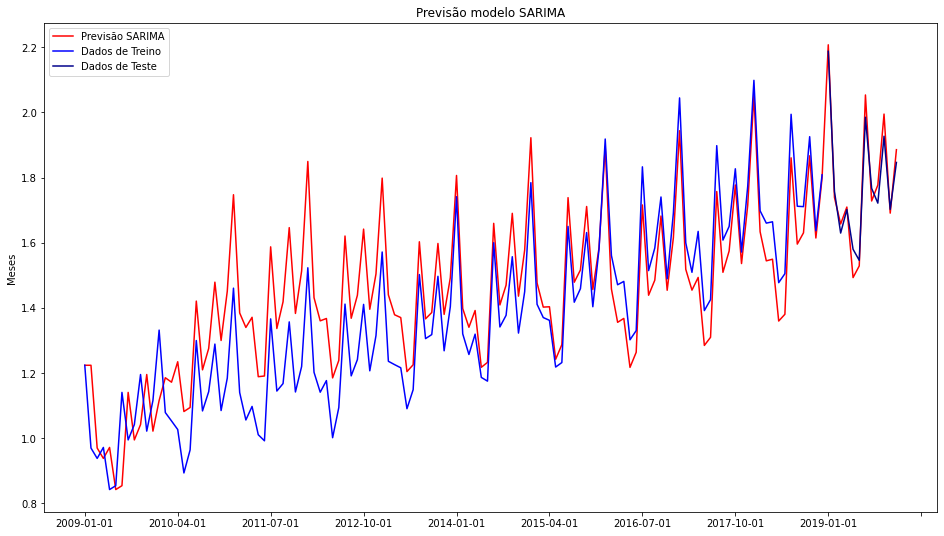

In [496]:

forecast = best_model.predict(start=0, end=passIn_train.shape[0] + 10)
predictions = reverse_logdiff(y0,forecast)

fig, ax =plt.subplots(figsize=(16, 9))
ax.plot(predictions, color='r', label='Previsão SARIMA')
ax.plot(passIn_train, label='Dados de Treino', color = 'b')

ax.plot(passIn_teste.index,passIn_teste.values, label='Dados de Teste', color = 'darkblue')
ax.xaxis.set_major_locator(plt.MaxNLocator(11))
ax.set_title('Previsão modelo SARIMA')
ax.set_ylabel('Número de passageiros [Em Milhões]')
ax.set_ylabel('Meses')
plt.legend()
plt.savefig('Images/PrevisaoSarima.jpeg')
plt.show()



In [455]:
print(f'A métrica MSE nos dados de treino é: {mean_squared_error(passIn_train.values,predictions[:-12]):5f}')
print(f'A métrica MSE nos dados de teste é: {mean_squared_error(passIn_teste.values,predictions[-12:]):5f}')

A métrica MSE nos dados de treino é: 0.021300
A métrica MSE nos dados de teste é: 0.002086


Como podemos ver, as métricas de teste obtidas com esta abordagem são menores do que com a abordagem anterior
Este modelo será então o escolhido para a predição. 

Este método caputra de forma muito mais clara a sazonalidade da série. Vemos um também uma deslocação temporal de uma unidade, porque se trata de uma modelagem de previsão. 

In [464]:
# Salvar o modelo 
# Para carregar o modelo é necessário a função SARIMAXResults
#from statsmodels.tsa.arima_model import ARIMAResults

best_model.save('Models/PassagensInSARIMA.pkl')

### Predição com base no continente de origem

Iremos repetir o procedimento anterior de modelagem de um modelo SARIMA mas desta vez para a predição do número de passageiros entrantes com base também no continente de origem do vôo. 

In [471]:
# Passageiros In por mês
passIn_CTtr =[]
passIn_CTtst = []
cont_list =df['Continentes'].unique()

for idx,continente in enumerate(cont_list):
    auxtr = df_train[df['Continentes'] == continente]
    auxtst = df_test[df['Continentes'] == continente]
    passIn_CTtr.append(auxtr.groupby('Month')['Passengers In'].sum()/1e3)
    passIn_CTtst.append(auxtst.groupby('Month')['Passengers In'].sum()/1e3)
    

C:\Users\pedro\AppData\Local\Temp/ipykernel_21436/1499251837.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  auxtr = df_train[df['Continentes'] == continente]
C:\Users\pedro\AppData\Local\Temp/ipykernel_21436/1499251837.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  auxtst = df_test[df['Continentes'] == continente]


In [472]:
# Iremos estacionarizar todos os dados de treinamento
passIn_CTtr_st =[]
y0s = []
first_diff.index = pd.DatetimeIndex(first_diff.index.values,
                               freq='MS')

for element in passIn_CTtr:
    y0s.append(np.log(element[0]))
    diff = np.log(element).diff()[1:]
    diff.index = pd.DatetimeIndex(diff.index.values,
                               freq='MS')
    passIn_CTtr_st.append(diff)
    

A otimização será feita para cada continente separadamente. Para realizá-la, basta descomentar as linhas de código abaixo, que foram comentadas para não repetir este processo demorado diversas vezes. 


In [473]:
# A otimização será feita para cada continente separadamente
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[0])
#result_df

In [474]:
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[1])
#result_df

In [475]:
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[2])
#result_df

In [476]:
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[3])
#result_df

In [477]:
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[4])
#result_df

In [478]:
#result_df = optimize_SARIMA(parameters_list, 1, 0, 12, passIn_CTtr_st[5])
#result_df

In [479]:

p = [2,3,3,5,4,5]
q = [4,4,4,5,5,4]
P = [0,0,0,0,0,0]
Q = [1,1,1,1,1,1]

model =[]

for idx,data in enumerate(passIn_CTtr_st):
    model.append(SARIMAX(data, 
                         order=(p[idx], 1,q[idx]), seasonal_order=(P[idx], 1, Q[idx], 12)).fit(dis=-1, maxiter=200))


C:\Users\pedro\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [500]:
# Realizar as predições para cada um dos continentes
forecast =[]
predictions =[]

for idx,mod in enumerate(model):
    forecast.append(mod.predict(start=0, end=passIn_CTtr[0].shape[0] + 10))
    predictions.append(reverse_logdiff(y0s[idx],forecast[idx]))

------------América do Sul-----------
A métrica MSE nos dados de treino é: 2.671533
A métrica MSE nos dados de teste é: 1.927888
------------Oceania-----------
A métrica MSE nos dados de treino é: 2081.526671
A métrica MSE nos dados de teste é: 276.636602
------------América do Norte-----------
A métrica MSE nos dados de treino é: 1113.694567
A métrica MSE nos dados de teste é: 3440.974764
------------Asia-----------
A métrica MSE nos dados de treino é: 18277.175581
A métrica MSE nos dados de teste é: 52706.044187
------------África-----------
A métrica MSE nos dados de treino é: 65.190272
A métrica MSE nos dados de teste é: 7.493265
------------Europa-----------
A métrica MSE nos dados de treino é: 43.207237
A métrica MSE nos dados de teste é: 69.484126


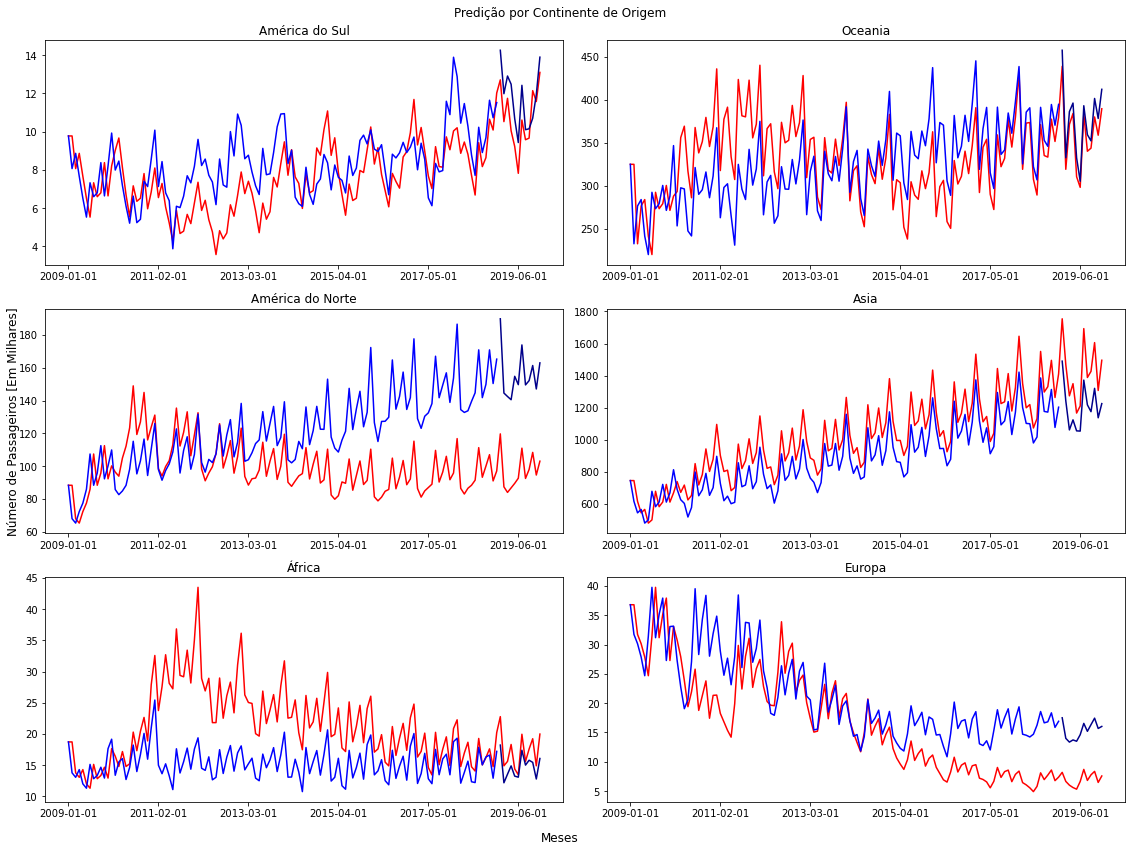

In [501]:
fig, axs = plt.subplots(nrows = 3, ncols = 2,
                       figsize=(16, 12))

axs = axs.flatten()

for idx,pred in enumerate(predictions):
    axs[idx].plot(pred, color = 'red',label = f'Predição: {cont_list[idx]}')
    axs[idx].plot(passIn_CTtr[idx].index, passIn_CTtr[idx].values, color = 'b',
                  label = f'Dados originais: {cont_list[idx]}')
    axs[idx].plot(passIn_CTtst[idx].index, passIn_CTtst[idx].values, color = 'darkblue',
                  label = f'Dados originais: {cont_list[idx]}')

    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(6))
    axs[idx].set_title(f'{cont_list[idx]}')
    print(f'------------{cont_list[idx]}-----------')
    print(f'A métrica MSE nos dados de treino é: {mean_squared_error(passIn_CTtr[idx].values,pred[:-12]):5f}')
    print(f'A métrica MSE nos dados de teste é: {mean_squared_error(passIn_CTtst[idx],pred[-12:]):5f}')

fig.suptitle('Predição por Continente de Origem')
fig.supylabel('Número de Passageiros [Em Milhares]')
fig.supxlabel('Meses')
plt.tight_layout()
plt.savefig('Images/Predicao_continente.jpeg')
plt.show()

In [502]:
# Salvar os modelos
for idx,mod in enumerate(model):
    mod.save(f'Models/SARIMA_{cont_list[idx]}')
